In [1]:
from qgis.core import (
    Qgis,
    QgsApplication,
    QgsVectorLayer,
    QgsProject,
    QgsPathResolver,
    QgsRectangle,
    QgsPrintLayout,
    QgsLayoutItemMap,
    QgsLayoutPoint,
    QgsLayoutSize,
    QgsUnitTypes,
    QgsLayoutItemLegend,
    QgsLayoutExporter,
    QgsLayoutItemMapGrid,
    QgsLayoutItemScaleBar,
    QgsLayoutItemLabel,
    QgsLayoutItemPicture,
    QgsCoordinateReferenceSystem,
    QgsLayerTreeLayer,
    QgsLineSymbol,
    QgsTextFormat,
)

from qgis.gui import (
    QgsLayerTreeMapCanvasBridge,
    QgsMapCanvas,
)

from qgis.PyQt.QtGui import (
    QColor,
    QFont,
    QFontMetricsF,
)

from qgis.utils import (
    iface,
)

import matplotlib.pyplot as plt
import shapely
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import os
import subprocess
import json
import configparser
from osgeo import gdal

In [2]:
def coords_to_bbox(coords,output_dir,i=0):
    '''
    coords must be in lon_min,lon_max,lat_min,lat_max, i.e. the output from the bbox drawing tool
    takes coordinates and turns them into a bounding box
    writes bounding box to a geojson file
    '''
    bbox = shapely.geometry.box(coords[0],coords[1],coords[2],coords[3])
    bbox_name = os.path.join(output_dir,f'bbox_{i}.geojson')
    gdf_bbox = gpd.GeoDataFrame(geometry=[bbox],crs='EPSG:4326')
    gdf_bbox.to_file(bbox_name,driver='GeoJSON')
    return bbox_name

def create_print_layout(**kwargs):
    return None

def create_legend(map,layout,legend_dict):
    legend_text = legend_dict['legend_text']
    remove_list = legend_dict['remove_list']
    background_color = legend_dict['background_color']
    font_color = legend_dict['font_color']
    fontsize = legend_dict['fontsize']
    legend_position = legend_dict['position']
    legend_inside_outside = legend_dict['inside_outside']
    x_offset = legend_dict['x_offset']
    y_offset = legend_dict['y_offset']
    legend = QgsLayoutItemLegend(layout)
    legend.setAutoUpdateModel(False)
    model = legend.model()
    root = model.rootGroup()
    for item in root.children():
        if isinstance(item, QgsLayerTreeLayer) and item.name() in remove_list:
            root.removeChildNode(item)
    legend.setLinkedMap(map)
    legend.setTitle(legend_text)
    legend.setWrapString('\\n')
    legend.setBackgroundColor(background_color)
    legend.setFontColor(font_color)
    map_item = [item for item in layout.items() if isinstance(item, QgsLayoutItemMap)][0]
    map_width = map_item.sizeWithUnits().width()
    map_height = map_item.sizeWithUnits().height()
    # legend.attemptMove(QgsLayoutPoint(map_width-1, map_height-1, QgsUnitTypes.LayoutMillimeters), useReferencePoint=True)
    legend.attemptMove(QgsLayoutPoint(x_offset, y_offset, QgsUnitTypes.LayoutMillimeters), useReferencePoint=True)
    #add legend to layout
    layout.addLayoutItem(legend)
    return map,layout,legend

def export_layout(layout,output_dir,export_file_type,dpi,layer_name):
    exporter = QgsLayoutExporter(layout)
    image_path = os.path.join(output_dir,f'{os.path.splitext(layer_name)[0]}.{export_file_type}')
    if export_file_type == 'png':
        export_settings = QgsLayoutExporter.ImageExportSettings()
        export_settings.dpi = dpi
        exporter.exportToImage(image_path, export_settings)
    elif export_file_type == 'pdf':
        export_settings = QgsLayoutExporter.PdfExportSettings()
        export_settings.dpi = dpi
        exporter.exportToPdf(image_path, export_settings)

def create_grid(map,layout,grid_dict):
    '''
    Builds grid around map
    '''
    grid_spacing = grid_dict['spacing']
    grid_width = grid_dict['width']
    grid_font = grid_dict['font']
    grid_precision = grid_dict['precision']
    map.grid().setUnits(QgsLayoutItemMapGrid.MapUnit)
    map.grid().setFrameStyle(QgsLayoutItemMapGrid.Zebra)
    map.grid().setStyle(QgsLayoutItemMapGrid.FrameAnnotationsOnly)
    map.grid().setAnnotationEnabled(True)
    map.grid().setAnnotationTextFormat(QgsTextFormat.fromQFont(grid_font))
    map.grid().setAnnotationFormat(QgsLayoutItemMapGrid.DecimalWithSuffix)
    map.grid().setAnnotationPrecision(grid_precision)
    # Left = 0, Right = 1, Top = 3, Bottom = 2
    # Appears that second number in setAnnotationDisplay is the side of the map and first number must be one higher to disable visibility
    map.grid().setAnnotationDisplay(2,1)
    map.grid().setAnnotationDisplay(3,2)
    map.grid().setFrameWidth(grid_width)
    map.grid().setIntervalX(grid_spacing)
    map.grid().setIntervalY(grid_spacing)
    map.grid().setCrs(QgsCoordinateReferenceSystem.fromEpsgId(4326))
    layout.refresh()
    return map,layout

def create_scalebar(map,layout,scalebar_dict,bbox_flag=False):
    '''
    Creates a scalebar for the map
    '''
    for item in list(layout.items()):  # Iterate over a copy to avoid issues when removing items
        if isinstance(item, QgsLayoutItemScaleBar):
            layout.removeItem(item)
    scalebar_x_offset = scalebar_dict['x_offset']
    scalebar_y_offset = scalebar_dict['y_offset']
    scalebar_units = scalebar_dict['units']
    scalebar_N_segments = scalebar_dict['N_segments']
    if bbox_flag == True:
        scalebar_length = scalebar_dict['length_bbox']
    else:
        scalebar_length = scalebar_dict['length']
    scalebar_font = scalebar_dict['font']
    scalebar_font_color = scalebar_dict['font_color']
    scalebar_style = scalebar_dict['style']
    scalebar = QgsLayoutItemScaleBar(layout)
    scalebar.setLinkedMap(map)
    scalebar.setStyle(scalebar_style)
    scalebar.setTextFormat(QgsTextFormat.fromQFont(scalebar_font))
    scalebar.setFontColor(scalebar_font_color)
    scalebar.setUnits(QgsUnitTypes.DistanceMeters)
    scalebar.setNumberOfSegments(scalebar_N_segments)
    scalebar.setNumberOfSegmentsLeft(0)
    scalebar.setUnitsPerSegment(scalebar_length)
    scalebar.setUnitLabel(scalebar_units)
    scalebar.attemptMove(QgsLayoutPoint(scalebar_x_offset, scalebar_y_offset, QgsUnitTypes.LayoutMillimeters), useReferencePoint=True)
    scalebar.update()
    layout.addLayoutItem(scalebar)
    layout.refresh()
    return map,layout

def create_north_arrow(map,layout,north_arrow_dict):
    '''
    
    '''
    north_arrow_x_offset = north_arrow_dict['x_offset']
    north_arrow_y_offset = north_arrow_dict['y_offset']
    north_arrow_image_path = north_arrow_dict['image_path']
    north_arrow_size = north_arrow_dict['size']
    north_arrow = QgsLayoutItemPicture(layout)
    north_arrow.setPicturePath(north_arrow_image_path)
    north_arrow.setLinkedMap(map)
    north_arrow.attemptResize(QgsLayoutSize(north_arrow_size, north_arrow_size,QgsUnitTypes.LayoutMillimeters))
    north_arrow.attemptMove(QgsLayoutPoint(north_arrow_x_offset, north_arrow_y_offset, QgsUnitTypes.LayoutMillimeters), useReferencePoint=True)
    layout.addLayoutItem(north_arrow)
    layout.refresh()
    return map,layout


def create_inundation_qml_file(**kwargs):
    default_file = kwargs['default_file']
    new_file = kwargs['new_file']
    color = kwargs['color']
    color_str = ','.join([str(c) for c in color])
    color_replacement =    f'      <Option type="QString" name="color" value="{color_str}"/>'
    color_replacement_command = f'sed \'160s$.*${color_replacement}$\' {default_file} > {new_file}' #replace line 160 with the new color
    subprocess.run(color_replacement_command,shell=True)
    return None

def create_outline_qml_file(**kwargs):
    default_file = kwargs['default_file']
    new_file = kwargs['new_file']
    fill_color = kwargs['fill_color']
    outline_color = kwargs['outline_color']
    outline_thickness = kwargs['outline_thickness']
    fill_color_str = ','.join([str(c) for c in fill_color])
    fill_color_replacement =        f'      <Option type="QString" name="color" value="{fill_color_str}"/>'
    fill_color_replacement_command = f'sed \'160s$.*${fill_color_replacement}$\' {default_file} > {new_file}' #replace line 160 with the new fill color
    outline_color_str = ','.join([str(c) for c in outline_color])
    outline_color_replacement =     f'      <Option type="QString" name="outline_color" value="{outline_color_str}"/>'
    outline_color_replacement_command = f'sed \'165s$.*${outline_color_replacement}$\' {new_file} > tmp.qml' #replace line 165 with the new outline color
    outline_thickness_replacement = f'      <Option type="QString" name="outline_width" value="{outline_thickness:.2f}"/>'
    outline_thickness_replacement_command = f'sed \'167s$.*${outline_thickness_replacement}$\' tmp.qml > {new_file}' #replace line 167 with the new outline thickness
    subprocess.run(fill_color_replacement_command,shell=True)
    subprocess.run(outline_color_replacement_command,shell=True)
    subprocess.run(outline_thickness_replacement_command,shell=True)
    subprocess.run(f'rm tmp.qml',shell=True)
    return None

def pt_to_mm(pt):
    return pt*25.4/72

def get_extent_shp(shp_file,crs_select='EPSG:4326',buffer=0,N_round=3):
    '''
    Uses ogrinfo to get the extent of a shapefile, which prevents reading the entire shapefile into memory
    Make sure buffer value is in the same units as crs_select, e.g. degrees for EPSG:4326
    Returns value in [x_min y_min x_max y_max] format
    '''
    ogrinfo_command = f'ogrinfo -json {shp_file} > tmp.json'
    subprocess.run(ogrinfo_command,shell=True)
    with open('tmp.json','r') as f:
        data = json.load(f)
    extent = data['layers'][0]['geometryFields'][0]['extent']
    crs = f'EPSG:{data["layers"][0]["geometryFields"][0]["coordinateSystem"]["projjson"]["id"]["code"]}'
    gdf_extent = gpd.GeoDataFrame(geometry=[shapely.geometry.box(*extent)],crs=crs)
    if crs != crs_select:
        gdf_extent = gdf_extent.to_crs(crs_select)
    extent_select = [np.round(np.min(gdf_extent.bounds.minx)-buffer,N_round),np.round(np.min(gdf_extent.bounds.miny)-buffer,N_round),np.round(np.max(gdf_extent.bounds.maxx)+buffer,N_round),np.round(np.max(gdf_extent.bounds.maxy)+buffer,N_round)]
    os.remove('tmp.json')
    return extent_select

def ISO_to_mm(iso_size='A4'):
    '''
    Converts ISO paper sizes to mm
    '''
    iso_dict = {
        'A0': [841,1189],
        'A1': [594,841],
        'A2': [420,594],
        'A3': [297,420],
        'A4': [210,297],
        'A5': [148,210],
        'A6': [105,148],
        'A7': [74,105],
        'A8': [52,74],
        'A9': [37,52],
        'A10': [26,37],
    }
    return iso_dict[iso_size]

def get_image_size(img):
    from PIL import Image
    im = Image.open(img)
    im.close()
    return im.size

def add_home(file_path):
    '''
    Adds home directory to starting tilde in file paths
    Using ~ instead of home directory can cause issues
    But ~ can mask username and make common file paths usable across machines with the same .ini file
    '''
    if file_path.startswith('~'):
        home_dir = os.path.expanduser('~')
        file_path = os.path.join(*[home_dir,'/'.join(file_path.split('/')[1:])])
    return file_path

def create_text_box(map,layout,text_box_dict):
    '''
    Creates a text box
    '''
    text_box_text = text_box_dict['text']
    text_box_x_offset = text_box_dict['x_offset']
    text_box_y_offset = text_box_dict['y_offset']
    text_box_font = text_box_dict['font']
    text_box = QgsLayoutItemLabel(layout)
    text_box.setText(text_box_text)
    text_box.attemptMove(QgsLayoutPoint(text_box_x_offset, text_box_y_offset, QgsUnitTypes.LayoutMillimeters), useReferencePoint=True)
    layout.addLayoutItem(text_box)
    layout.refresh()
    return map,layout

def create_logo(map,layout,logo_dict):
    logo_file = logo_dict['file']
    logo_x_size = logo_dict['x_size']
    logo_y_size = logo_dict['y_size']
    logo_x_offset = logo_dict['x_offset']
    logo_y_offset = logo_dict['y_offset']
    # logo_size = logo_dict['size']
    logo_dpi_export = logo_dict['dpi_export']
    logo = QgsLayoutItemPicture(layout)
    logo.setPicturePath(logo_file)
    logo.setLinkedMap(map)
    logo.attemptResize(QgsLayoutSize(logo_x_size/logo_dpi_export*25.4, logo_y_size/logo_dpi_export*25.4,QgsUnitTypes.LayoutMillimeters))
    logo.attemptMove(QgsLayoutPoint(logo_x_offset, logo_y_offset, QgsUnitTypes.LayoutMillimeters), useReferencePoint=True)
    layout.addLayoutItem(logo)
    layout.refresh()
    return map,layout

def calculate_position(map_size, location, feature_size, offset=(0, 0)):
    """
    Calculate the x and y position of a map feature based on input map size and location.

    Parameters:
    map_size (tuple): Size of the map in millimeters (width, height).
    location (str): Location of the feature ('top_left', 'top_right', 'bottom_left', 'bottom_right').
    feature_size (tuple): Size of the feature in millimeters (width, height).
    offset (tuple): Offset from the calculated position (x_offset, y_offset).

    Returns:
    QgsLayoutPoint: Calculated position as QgsLayoutPoint.
    Example usage:
    map_size = (297, 210)  # A4 size in mm
    location = 'bottom_right'
    offset = (10, 10)  # 10 mm offset from the bottom right corner
    position = calculate_position(map_size, location, offset)
    print(position)
    """
    width, height = map_size
    x_feature, y_feature = feature_size
    x_offset, y_offset = offset
    if location == 'top_left':
        x = x_offset
        y = y_offset
    elif location == 'top_right':
        x = width - x_offset
        y = y_offset
    elif location == 'bottom_left':
        x = x_offset
        y = height - y_offset
    elif location == 'bottom_right':
        x = width - x_offset
        y = height - y_offset
    else:
        raise ValueError("Invalid location. Choose from 'top_left', 'top_right', 'bottom_left', 'bottom_right'.")
    return QgsLayoutPoint(x, y, QgsUnitTypes.LayoutMillimeters)


In [3]:
#Read config file
config = configparser.ConfigParser()
config_file = 'qgis_config.ini'
if not os.path.isfile(config_file):
    raise FileNotFoundError(f'Config file {config_file} not found. Please create a config file with the necessary paths.')
config.read(config_file)
# Define settings
testing_flag = config.getboolean('FLAGS','testing') #With testing it will only run the first file for speed
project_name = config.get('GENERAL','project_name')
input_csv = add_home(config.get('GENERAL_PATHS','input_csv'))
install_dir = add_home(config.get('CONFIG','install_dir'))
working_dir = add_home(config.get('GENERAL_PATHS','working_dir'))
output_dir = os.path.join(*[working_dir,f'Output_{project_name}_{datetime.datetime.now().strftime("%Y%m%dT%H%M%S")}'])
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)

# Input CSV should have full path to file,legend name,
df_input = pd.read_csv(input_csv)

default_inundation_file = os.path.abspath(config.get('GENERAL_PATHS','default_inundation_file'))
default_outline_file = os.path.abspath(config.get('GENERAL_PATHS','default_outline_file'))
default_nodata_file = os.path.abspath(config.get('GENERAL_PATHS','default_nodata_file'))
default_logo = os.path.abspath(config.get('GENERAL_PATHS','default_logo'))

if default_logo is not None:
    logo_x_size,logo_y_size = get_image_size(default_logo)
else:
    logo_x_size,logo_y_size = 0,0

# Define extent of map
# extent = [123.882,10.233,124.069,10.339]
extent = config.get('OPTIONS','extent',fallback='default')
if extent == 'default':
    extent = get_extent_shp(df_input.filename[0],crs_select='EPSG:4326',buffer=0.01)
else:
    extent = [float(coord) for coord in extent.split(',')]

extent_qgis = QgsRectangle(*extent)
extent_ratio = (extent[2]-extent[0])/(extent[3]-extent[1])

# Define output size (either in mm or ISO paper size)
export_file_type = config.get('CONFIG','export_file_type',fallback='png') #options are 'png' or 'pdf'
dpi_export = config.getint('CONFIG','dpi_export',fallback=200)
output_size = config.get('CONFIG','output_size',fallback='A4')
if output_size in ['A4','A3','A2','A1','A0']:
    output_size = ISO_to_mm(output_size)

if extent_ratio > 1:
    output_orientation = 'horizontal'
    output_size = [output_size[1],output_size[0]]
else:
    output_orientation = 'vertical'

# Inundation colors, which take the format [R,G,B,A]
inundation_opacity = config.getfloat('OPTIONS','opacity_inundation',fallback=0.5)
inundation_color_connected = [int(clr) for clr in config.get('OPTIONS','color_connected_inundation',fallback='255,0,0').split(',')]
if len(inundation_color_connected) == 3: # If only RGB is provided, add opacity
    inundation_color_connected.append(int(255*inundation_opacity))
inundation_connected_qml = os.path.join(*[output_dir,'inundation_connected.qml'])
create_inundation_qml_file(default_file=default_inundation_file,new_file=inundation_connected_qml,color=inundation_color_connected)
inundation_color_disconnected = [int(clr) for clr in config.get('OPTIONS','color_disconnected_inundation',fallback='255,255,0').split(',')]
if len(inundation_color_disconnected) == 3: # If only RGB is provided, add opacity
    inundation_color_disconnected.append(int(255*inundation_opacity))
inundation_disconnected_qml = os.path.join(*[output_dir,'inundation_disconnected.qml'])
create_inundation_qml_file(default_file=default_inundation_file,new_file=inundation_disconnected_qml,color=inundation_color_disconnected)

# Bounding box settings
bbox_outline_color = [int(clr) for clr in config.get('OPTIONS','color_bbox',fallback='255,255,255').split(',')]
bbox_outline_color.append(255)
bbox_fill_opacity = config.getfloat('OPTIONS','opacity_bbox',fallback=0.0)
bbox_fill_color = [int(clr) for clr in config.get('OPTIONS','color_bbox',fallback='255,255,255').split(',')]
if len(bbox_fill_color) == 3: # If only RGB is provided, add opacity
    bbox_fill_color.append(int(255*bbox_fill_opacity))
bbox_outline_thickness = config.getfloat('OPTIONS','outline_thickness_bbox',fallback=0.2)
bbox_qml = os.path.join(*[output_dir,'bbox.qml'])
create_outline_qml_file(default_file=default_outline_file,new_file=bbox_qml,fill_color=bbox_fill_color,outline_color=bbox_outline_color,outline_thickness=bbox_outline_thickness)

#coordinates for bbox in lon_min,lon_max,lat_min,lat_max
bbox_coords = []
N_bbox = len(config['BBOX'])
for i in range(N_bbox):
    bbox_coords.append([float(coord) for coord in config['BBOX'][f'bbox_{i}'].split(',')])
    # bbox_files.append(coords_to_bbox(bbox_coords[-1],output_dir,i))
bbox_files = [coords_to_bbox(coords,output_dir,i) for i,coords in enumerate(bbox_coords)]

#Basemap settings
basemap_options = ['Bing Aerial','Google Satellite','OpenStreetMap']
basemap_select = config.get('OPTIONS','basemap_select',fallback='Bing Aerial')
if basemap_select not in basemap_options:
    raise ValueError(f'Basemap select {basemap_select} not in options ({", ".join(basemap_options)}). Please select a valid basemap.')

#Other layers to add (as dict with layer path and legend name and flag for visibility in legend):
coast_outline_color = [int(clr) for clr in config.get('OPTIONS','color_coast',fallback='255,255,255').split(',')]
coast_outline_color.append(255)
coast_fill_opacity = config.getfloat('OPTIONS','opacity_coast',fallback=0.0)
coast_fill_color = [255,255,255,int(255*coast_fill_opacity)]
coast_outline_thickness = config.getfloat('OPTIONS','outline_thickness_coast',fallback=0.2)
coast_qml = os.path.join(*[output_dir,'coast.qml'])
create_outline_qml_file(default_file=default_outline_file,new_file=coast_qml,fill_color=coast_fill_color,outline_color=coast_outline_color,outline_thickness=coast_outline_thickness)

nodata_outline_color = [int(clr) for clr in config.get('OPTIONS','color_nodata',fallback='255,255,255').split(',')]
nodata_outline_color.append(255)
nodata_fill_opacity = config.getfloat('OPTIONS','opacity_nodata',fallback=0.0)
nodata_fill_color = [255,255,255,int(255*nodata_fill_opacity)]
nodata_outline_thickness = config.getfloat('OPTIONS','outline_thickness_nodata',fallback=0.2)
nodata_qml = os.path.join(*[output_dir,'nodata.qml'])
create_outline_qml_file(default_file=default_nodata_file,new_file=nodata_qml,fill_color=nodata_fill_color,outline_color=nodata_outline_color,outline_thickness=nodata_outline_thickness)



extra_layer_dict = {}
for i in range(int(np.floor(len(config['EXTRA_LAYERS'])/4))):
    extra_layer_dict[i] = {
        'filename' : add_home(config['EXTRA_LAYERS'][f'filename_{i}']), #path to layer file, not necessarily in output_dir
        'legend_name' : config['EXTRA_LAYERS'][f'legend_name_{i}'], #legend name if visible
        'legend_visible' : config.getboolean('EXTRA_LAYERS',f'legend_visible_{i}'), #flag for visibility in final legend
        'style' : os.path.join(*[output_dir,config['EXTRA_LAYERS'][f'style_{i}']]), #style .qml file must be in output_dir
    }


# Legend settingss
legend_remove_list = basemap_options.copy()
legend_remove_list.extend([f'bbox_{i}' for i in range(N_bbox)])
legend_remove_list.extend([extra_layer_dict[i]['legend_name'] for i in range(len(extra_layer_dict))])

QgsApplication.setPrefixPath(install_dir,True)
qgs = QgsApplication([], False)
qgs.initQgis()

TESTING MODE
Creating Project:
 
Project name: Philippines_LapuLapu
Working directory: /Users/edhe8255/Dropbox/TU/PhD/Projects/QGIS_Automation
Output directory: /Users/edhe8255/Dropbox/TU/PhD/Projects/QGIS_Automation/Output_Philippines_LapuLapu_20250625T145521
Export file type: png
Output size: 297 x 210 mm
Output orientation: horizontal
Export DPI: 200
Basemap: Bing Aerial
Creating 2 scenarios
Extent: [np.float64(123.922), np.float64(10.232), np.float64(124.056), np.float64(10.345)]
2 bounding boxes:
Bounding box 0: [123.974, 10.305, 123.991, 10.317]
Bounding box 1: [123.956, 10.264, 123.984, 10.276]
Inundation colors:


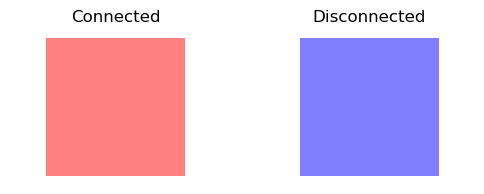

In [4]:
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(6,2))
ax[0].scatter(1,1,color=[c/255 for c in inundation_color_connected],marker='s',s=1e4,edgecolor='None')
ax[0].set_title('Connected')
ax[0].axis('off')
ax[1].scatter(1,1,color=[c/255 for c in inundation_color_disconnected],marker='s',s=1e4,edgecolor='None')
ax[1].set_title('Disconnected')
ax[1].axis('off')

if testing_flag == True:
    print('TESTING MODE')
    df_input = df_input.head(2)
print('Creating Project:')
print(' ')
print(f'Project name: {project_name}')
print(f'Working directory: {working_dir}')
print(f'Output directory: {output_dir}')
print(f'Export file type: {export_file_type}')
print(f'Output size: {output_size[0]} x {output_size[1]} mm')
print(f'Output orientation: {output_orientation}')
print(f'Export DPI: {dpi_export}')
print(f'Basemap: {basemap_select}')
print(f'Creating {len(df_input)} scenarios')
print(f'Extent: {extent}')
if N_bbox > 0:
    print(f'{N_bbox} bounding boxes:')
    for i in range(N_bbox):
        print(f'Bounding box {i}: {bbox_coords[i]}')
print(f'Inundation colors:')

In [5]:
#Other options:

scalebar_dict = {
    'position' : config.get('SCALEBAR','position',fallback='bottom_right'),
    'units' : config.get('SCALEBAR','units',fallback='m'),
    'N_segments' : config.getint('SCALEBAR','N_segments',fallback=2),
    'length' : config.getint('SCALEBAR','length',fallback=1000),
    'length_bbox' : config.getint('SCALEBAR','length_bbox',fallback=config.getint('SCALEBAR','length',fallback=1000)),
    'style' : 'Single Box',
    'font' : QFont(config.get('SCALEBAR','font',fallback='Arial'),config.getint('SCALEBAR','fontsize',fallback=12)),
    'font_color' : QColor(255,255,255,255),
    'scalebar_font_buffer_color' : 'black',
}

legend_dict = {
    'position' : 'bottom_left',
    'title' : '',
    'style' : '',
    'font' : '',
    'fontsize' : '',
    'font_color' : QColor(255,255,255,255),
    'background_color' : QColor(0,0,0,120),
    'inside_outside' : 'outside',
    'remove_list' : legend_remove_list,
}

north_arrow_dict = {
    'style' : '',
    'position' : 'top_left',
    'width' : 50,
    'image_path' : os.path.join(*[working_dir,'defaults/north_arrow.svg']),
    'size' : 18
}

grid_dict = {
    'style' : config.get('GRID','style',fallback='zebra'),
    'font' : QFont(config.get('GRID','font',fallback='Arial'),config.getint('GRID','fontsize',fallback=14)),
    'font_color' : config.get('GRID','font_color',fallback='black'),
    'spacing' : config.getfloat('GRID','spacing',fallback=0.1),
    'spacing_bbox' : config.getfloat('GRID','spacing_bbox',fallback=0.01),
    'visible' : [True,False,True,False], #top,bottom,left,right
    'width' : config.getfloat('GRID','width',fallback=2.0),
    'precision' : config.getint('GRID','precision',fallback=2),
}

text_box_dict = {
    'text' : f'Background image copyright {basemap_select}',
    'position' : 'bottom_left',
    'font' : QFont('Arial',16),
    'font_color' : QColor(0,0,0,255),
    'background_color' : '',
}

logo_dict = {
    'file' : default_logo,
    'position' : 'top_right',
    'inside_outside' : 'outside',
    'x_size' : logo_x_size,
    'y_size' : logo_y_size,
    'dpi_export' : dpi_export,
}

In [6]:
canvas = QgsMapCanvas()
canvas.show()

# Load project which has the base layers in EPSG:4326
project = QgsProject.instance()
project_file = add_home(config.get('GENERAL_PATHS','project_template'))
project.read(project_file)

canvas.setExtent(extent_qgis)
canvas.refresh()
# Uncheck all base layers and then re-check the selected one
for layer in project.mapLayers().values():
    project.layerTreeRoot().findLayer(layer).setItemVisibilityChecked(False)

project.layerTreeRoot().findLayer(project.mapLayersByName(basemap_select)[0]).setItemVisibilityChecked(True)

for i in range(len(extra_layer_dict)):
    vlayer = QgsVectorLayer(extra_layer_dict[i]['filename'],extra_layer_dict[i]['legend_name'],'ogr')
    # QgsProject.instance().addMapLayer(vlayer)
    project.addMapLayer(vlayer)
    vlayer.loadNamedStyle(extra_layer_dict[i]['style'])
    # vlayer.setVisible(extra_layer_dict[i]['legend_visible'])

for i in range(N_bbox):
    vlayer = QgsVectorLayer(bbox_files[i],f'bbox_{i}','ogr')
    # QgsProject.instance().addMapLayer(vlayer)
    project.addMapLayer(vlayer)
    vlayer.loadNamedStyle(bbox_qml)
    # vlayer.setVisible(True)



In [7]:
'''
Create print layout here
Set up the print layout with legend, scale bar, title, grid, etc
Load first inundation layer to style legend and then toggle visibility
'''
layout = QgsPrintLayout(project)
layout.initializeDefaults()

layout.setName("MyLayout")
project.layoutManager().addLayout(layout)

map = QgsLayoutItemMap(layout)
# Set map item position and size (by default, it is a 0 width/0 height item placed at 0,0)
# Reposition map based on border and resize to fit ISO ratio

# x_offset = np.ceil(QFontMetricsF(grid_dict['font']).horizontalAdvance(f'{1000-10**(-1*grid_dict["precision"])}°W') / dpi_export * 25.4 * 100)/100
# x_offset = np.ceil(QFontMetricsF(grid_dict['font']).horizontalAdvance('100°W') / dpi_export * 25.4)

# need to add x and y offset to legend dict too
# Use it to build a function that calculates the right x and y position based on inputs like "bottom_left" and "inside" or "outside"
x_offset = 31
y_offset = np.ceil((grid_dict['width'] + pt_to_mm(grid_dict['font'].pointSize()))*100)/100

legend_dict['x_offset'] = x_offset
legend_dict['y_offset'] = y_offset

scalebar_dict['x_offset'] = x_offset
scalebar_dict['y_offset'] = y_offset+175

north_arrow_dict['x_offset'] = x_offset+230
north_arrow_dict['y_offset'] = y_offset+165

text_box_dict['x_offset'] = x_offset
text_box_dict['y_offset'] = y_offset+195

logo_dict['x_offset'] = x_offset+180
logo_dict['y_offset'] = y_offset

map.attemptMove(QgsLayoutPoint(x_offset,y_offset, QgsUnitTypes.LayoutMillimeters))
# map.attemptResize(QgsLayoutSize(output_size[0]-40,output_size[1]-18, QgsUnitTypes.LayoutMillimeters))
# map.attemptResize(QgsLayoutSize(output_size[0]+50,output_size[1]-105, QgsUnitTypes.LayoutMillimeters))


if project_name == 'Philippines_Danajon':
    map.attemptResize(QgsLayoutSize(output_size[0]-35,output_size[1]-20, QgsUnitTypes.LayoutMillimeters))
elif project_name == 'Philippines_LapuLapu':
    map.attemptResize(QgsLayoutSize(output_size[0]-35,output_size[1]-20, QgsUnitTypes.LayoutMillimeters))
elif project_name == 'Philippines_SiargaoIsland':
    map.attemptResize(QgsLayoutSize(output_size[0]+40,output_size[1]-105, QgsUnitTypes.LayoutMillimeters))
elif project_name == 'Philippines_Navotas':
    pass


# Provide an extent to render
map.zoomToExtent(canvas.extent())
layout.addLayoutItem(map)

map,layout = create_grid(map,layout,grid_dict)
map,layout = create_scalebar(map,layout,scalebar_dict,bbox_flag=False)
map,layout = create_north_arrow(map,layout,north_arrow_dict)
# map,layout = create_logo(map,layout,logo_dict)
map,layout = create_text_box(map,layout,text_box_dict)

gdal.PushErrorHandler('CPLQuietErrorHandler')
for i in range(len(df_input)):
    inundation_main_file = df_input['filename'][i]
    connected_file = inundation_main_file.replace('.shp','_connectivity.shp')
    disconnected_file = inundation_main_file.replace('.shp','_disconnected.shp')
    vlayer_connected = QgsVectorLayer(connected_file,'Inundation (Connected)','ogr')
    vlayer_disconnected = QgsVectorLayer(disconnected_file,'Inundation (Disconnected)','ogr')
    project.addMapLayer(vlayer_connected)
    project.addMapLayer(vlayer_disconnected)
    vlayer_connected.loadNamedStyle(inundation_connected_qml)
    vlayer_disconnected.loadNamedStyle(inundation_disconnected_qml)
    project.layerTreeRoot().findLayer(vlayer_connected).setItemVisibilityChecked(True)
    project.layerTreeRoot().findLayer(vlayer_disconnected).setItemVisibilityChecked(True)
    legend_dict['legend_text'] = df_input['legend_entry'][i]
    map,layout,legend = create_legend(map,layout,legend_dict)
    map,layout = create_scalebar(map,layout,scalebar_dict,bbox_flag=False)
    export_layout(layout,output_dir,export_file_type,dpi_export,os.path.basename(inundation_main_file))
    #Because the legend changes dynamically with each entry, we need to add and remove it each time
    layout.removeLayoutItem(legend)
    project.removeMapLayer(vlayer_connected)
    project.removeMapLayer(vlayer_disconnected)
    for j in range(N_bbox):
        map,layout = create_scalebar(map,layout,scalebar_dict,bbox_flag=True)
        vlayer_bbox = QgsVectorLayer(bbox_files[j],f'bbox_{j}','ogr')
        map.zoomToExtent(vlayer_bbox.extent())
        # project.removeMapLayer(vlayer_bbox)
        project.removeMapLayer(project.mapLayersByName(f'bbox_{j}')[0].id())
        vlayer_connected = QgsVectorLayer(connected_file,'Inundation (Connected)','ogr')
        vlayer_disconnected = QgsVectorLayer(disconnected_file,'Inundation (Disconnected)','ogr')
        project.addMapLayer(vlayer_connected)
        project.addMapLayer(vlayer_disconnected)
        vlayer_connected.loadNamedStyle(inundation_connected_qml)
        vlayer_disconnected.loadNamedStyle(inundation_disconnected_qml)
        project.layerTreeRoot().findLayer(vlayer_connected).setItemVisibilityChecked(True)
        project.layerTreeRoot().findLayer(vlayer_disconnected).setItemVisibilityChecked(True)
        legend_dict['legend_text'] = df_input['legend_entry'][i]
        map,layout,legend = create_legend(map,layout,legend_dict)
        # Resize map to fit bbox
        # example: map.attemptResize(QgsLayoutSize(output_size[0]-35,output_size[1]-40, QgsUnitTypes.LayoutMillimeters))
        bbox_filename = f'{os.path.splitext(os.path.basename(inundation_main_file))[0]}_zoom_{j}'
        export_layout(layout,output_dir,export_file_type,dpi_export,bbox_filename)
        layout.removeLayoutItem(legend)
        project.removeMapLayer(vlayer_connected)
        project.removeMapLayer(vlayer_disconnected)
        project.addMapLayer(vlayer_bbox)
        vlayer_bbox.loadNamedStyle(bbox_qml)
        map.zoomToExtent(canvas.extent())
        # canvas.refresh()
        # layout.refresh()

    






/var/folders/r4/_m6ttf6x6nn1n7kygyjc9tcm0000gp/T/ipykernel_7140/1308801944.py:107: DeprecationWarning: QgsLayoutItemScaleBar.setFontColor() is deprecated
  scalebar.setFontColor(scalebar_font_color)
/var/folders/r4/_m6ttf6x6nn1n7kygyjc9tcm0000gp/T/ipykernel_7140/1308801944.py:37: DeprecationWarning: QgsLayoutItemLegend.setFontColor() is deprecated
  legend.setFontColor(font_color)
